<a href="https://colab.research.google.com/github/HagarTibi/Image-Restoration-with-Diffusion-Model-24-2-R-5/blob/main/diffCOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Update project path to the exact location of your main project files
project_path = '/content/drive/MyDrive/CamoDiffusion-main/'

# Navigate to the project folder
os.chdir(project_path)

# Verify the current working directory
print("Current Directory:", os.getcwd())


Current Directory: /content/drive/.shortcut-targets-by-id/1gO6o32tK2__6XSiKExiXFUmo_Q0EpQ-O/CamoDiffusion-main


Requirments Installation

In [ ]:
!pip install -r requirements.txt --verbose


Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Training The Model

In [ ]:
!accelerate launch --num_processes=1 --num_machines=1 --mixed_precision=no --dynamo_backend=no \
    /content/drive/MyDrive/CamoDiffusion-main/train.py \
    --config /content/drive/MyDrive/CamoDiffusion-main/config/camoDiffusion_352x352.yaml \
    --num_epoch=10 --batch_size=16 --gradient_accumulate_every=1


CUDA Available: True

train_dataset:
	name:		dataset.data_val.PolypObjDataset
	params:
		image_root:			/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs/
		gt_root:			/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT/
		trainsize:			352
		boundary_modification:			True
test_dataset:
	BrainMRI:
		name:			dataset.data_val.test_dataset
		params:
			image_root:				/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs/
			gt_root:				/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT/
			testsize:				352
project_name:	CamoDiffusion
__base__:	[]
model:
	name:		model.net.net
	params:
		class_num:			1
		mask_chans:			1
cond_uvit:
	name:		model.net.EmptyObject
	params:
		conditioning_klass:			model.net.EmptyObject
diffusion_model:
	name:		model.SimpleDiffSef.CondGaussianDiffusion
	params:
		model:			None
		image_size:			352
		channels:			1
		cond_channels:			3
		noise_d:			64
		num_sample_steps:			10
		clip_sample_denoised:

Sample Test

In [ ]:
!accelerate launch --num_processes=1 --num_machines=1 --mixed_precision=no --dynamo_backend=no \
    /content/drive/MyDrive/CamoDiffusion-main/sample.py \
    --config /content/drive/MyDrive/CamoDiffusion-main/config/camoDiffusion_384x384.yaml \
    --results_folder /content/drive/MyDrive/CamoDiffusion-main/results/ \
    --checkpoint /content/wandb/latest-run/model-best.pt \
    --num_sample_steps 10 \
    --target_dataset BrainMRI \
    --time_ensemble


/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
100% 51/51 [03:25<00:00,  4.02s/it]
BrainMRI mae: 0.027095667804916398
  0% 0/404 [00:00<?, ?it/s]Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256, 256), Shape of gt: (256, 256)
Shape of pred: (256,

Smeasure & Psnr

In [ ]:
import os
import cv2
import numpy as np

def _object(pred, gt):
    fg = pred * gt
    bg = (1 - pred) * (1 - gt)
    u = np.mean(gt)

    if u == 0:
        return 1 - np.mean(pred)
    elif u == 1:
        return np.mean(pred)
    else:
        fg_score = np.sum(fg) / (np.sum(gt) + 1e-8)
        bg_score = np.sum(bg) / (np.sum(1 - gt) + 1e-8)
        return u * fg_score + (1 - u) * bg_score

def _region(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / (union + 1e-8)

def calculate_smeasure(gt_path, pred_path):
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    if gt is None or pred is None:
        print(f"Error reading GT or Prediction file: {gt_path}, {pred_path}")
        return None

    gt_binary = (gt > 128).astype(np.uint8)  # Binarize GT
    pred_normalized = pred / 255.0           # Normalize Prediction

    alpha = 0.5
    sm = alpha * _object(pred_normalized, gt_binary) + (1 - alpha) * _region(pred_normalized, gt_binary)
    return sm

def calculate_psnr(gt_path, pred_path):
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    if gt is None or pred is None:
        print(f"Error reading GT or Prediction file: {gt_path}, {pred_path}")
        return None

    mse = np.mean((gt.astype(np.float32) - pred.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match

    pixel_max = 255.0
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

def compute_metrics_for_folders(gt_folder, pred_folder):
    gt_files = sorted([f for f in os.listdir(gt_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])
    pred_files = sorted([f for f in os.listdir(pred_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

    if len(gt_files) != len(pred_files):
        print("Mismatch in the number of files between GT and Prediction folders.")
        return

    total_smeasure = 0
    total_psnr = 0
    valid_count = 0

    for gt_file, pred_file in zip(gt_files, pred_files):
        gt_path = os.path.join(gt_folder, gt_file)
        pred_path = os.path.join(pred_folder, pred_file)

        sm = calculate_smeasure(gt_path, pred_path)
        psnr = calculate_psnr(gt_path, pred_path)

        if sm is not None and psnr is not None:
            total_smeasure += sm
            total_psnr += psnr
            valid_count += 1

    if valid_count > 0:
        average_smeasure = total_smeasure / valid_count
        average_psnr = total_psnr / valid_count
        print(f"Average Smeasure: {average_smeasure:.4f}")
        print(f"Average PSNR: {average_psnr:.4f} dB")
    else:
        print("No valid files processed.")

# Define paths to the GT and Prediction folders
gt_folder = "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT"
pred_folder = "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI"

# Compute metrics
compute_metrics_for_folders(gt_folder, pred_folder)


Average Smeasure: 0.5346
Average PSNR: 17.3659 dB



Visualize Results

Visualizing: TCGA_HT_8114_19981030_13.png | Non-black pixels: 2324 | IoU: 0.5962


KeyboardInterrupt: 

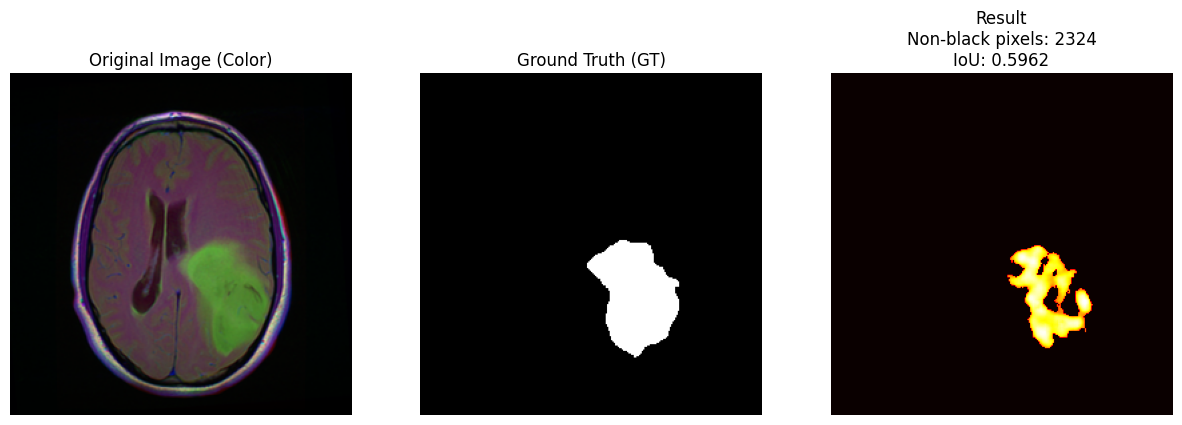

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Define paths
image_folder = "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs"
gt_folder = "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT"
result_folder = "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI"
save_folder = "/content/drive/MyDrive/CamoDiffusion-main/visualizations"
os.makedirs(save_folder, exist_ok=True)

# Compute IoU (Intersection over Union)
def compute_iou(gt, result):
    intersection = np.logical_and(gt > 0, result > 0).sum()
    union = np.logical_or(gt > 0, result > 0).sum()
    return intersection / union if union > 0 else 0.0

# Function to load and visualize images in color
def visualize_results_in_color(image_name, non_black_count, iou_score, pdf=None):
    image_path = os.path.join(image_folder, image_name)
    gt_path = os.path.join(gt_folder, image_name.replace(".png", "_mask.png"))
    result_path = os.path.join(result_folder, image_name)

    try:
        # Load images
        image = cv2.imread(image_path)  # Load in color
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)

        if image is None or gt is None or result is None:
            raise FileNotFoundError(f"One or more files missing for {image_name}")

        # Plot the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display
        axes[0].set_title("Original Image (Color)")
        axes[0].axis("off")

        axes[1].imshow(gt, cmap='gray')
        axes[1].set_title("Ground Truth (GT)")
        axes[1].axis("off")

        axes[2].imshow(result, cmap='hot')  # Enhanced color map for results
        axes[2].set_title(f"Result\nNon-black pixels: {non_black_count}\nIoU: {iou_score:.4f}")
        axes[2].axis("off")

        # Save the visualization
        plt.tight_layout()
        save_path = os.path.join(save_folder, f"visualization_{image_name}")
        plt.savefig(save_path)
        if pdf:
            pdf.savefig(fig)  # Save to the PDF
        plt.close(fig)  # Close the figure

    except FileNotFoundError as e:
        print(e)
    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# List all images in the Testing_Imgs folder
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])

# Evaluate and rank results based on IoU and non-black pixels
results_evaluation = []
for image_file in image_files:
    result_path = os.path.join(result_folder, image_file)
    gt_path = os.path.join(gt_folder, image_file.replace(".png", "_mask.png"))
    try:
        result = cv2.imread(result_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if result is not None and gt is not None:
            non_black_pixels = (result > 0).sum()
            iou_score = compute_iou(gt, result)
            results_evaluation.append((image_file, non_black_pixels, iou_score))
    except Exception as e:
        print(f"Error processing result: {result_path}, {e}")

# Sort by IoU score and non-black pixels
sorted_results = sorted(results_evaluation, key=lambda x: (x[2], x[1]), reverse=True)

# Save visualizations to a PDF
pdf_path = os.path.join(save_folder, "results_visualizations.pdf")
with PdfPages(pdf_path) as pdf:
    # Visualize results for the top N images
    top_n = 15  # Number of images to visualize
    for image_file, non_black_count, iou_score in sorted_results[:top_n]:
        print(f"Visualizing: {image_file} | Non-black pixels: {non_black_count} | IoU: {iou_score:.4f}")
        visualize_results_in_color(image_file, non_black_count, iou_score, pdf)

print(f"PDF with visualizations saved to: {pdf_path}")


Count files in all folders

In [ ]:
import os

def count_files_in_directory(directory):
    """
    Counts the number of files in the specified directory.

    Parameters:
        directory (str): Path to the directory to count files in.

    Returns:
        int: Number of files in the directory.
    """
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return 0

    file_count = len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return file_count

# Directories to process
directories = [
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT",
    "/content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs",
    "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI",
]

# Count and print the number of files in each directory
for dir_path in directories:
    file_count = count_files_in_directory(dir_path)
    print(f"Directory: {dir_path}, File Count: {file_count}")


Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_GT, File Count: 404
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Testing_Imgs, File Count: 404
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_GT, File Count: 961
Directory: /content/drive/MyDrive/CamoDiffusion-main/media/BrainMRI/Training_Imgs, File Count: 961
Directory: /content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI, File Count: 0


Delete Last Result

In [ ]:
import os

def delete_all_files(directory):
    """
    Deletes all files in the specified directory.

    Parameters:
        directory (str): Path to the directory to clear.
    """
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Failed to delete {file_path}: {e}")

# Path to the directory to clear
directory_to_clear =  "/content/drive/MyDrive/CamoDiffusion-main/results/BrainMRI"

# Delete all files in the directory
delete_all_files(directory_to_clear)

print("Deletion process completed.")


Deletion process completed.
